In [15]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score,axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [3]:
class RoastBot(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, batch_size, units):
        super(RoastBot, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Dense(embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        # x shape after embedding = (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation = (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        
        # pass the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # shape = (batch_size, max_len, hidden_size)
        x = self.fc1(output)
        
        # x shape = (batch_size * max_len, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        
        # output shape = (batch_size * max_len, vocab)
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [4]:
# using InceptionV3 to generate latent encodings for all the images in the dataset
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = inceptionv3.input
hidden_layer = inceptionv3.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [5]:
def load_image(image_path):
    
    img = to_rgb(cv2.imread(image_path))
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [36]:
faces_encodings = {}
for imgfile in tqdm(os.listdir('./faces')):
    if os.path.exists(os.path.join('./faces',imgfile)):
        img = load_image(os.path.join('./faces',imgfile))
        latent_encoding = image_features_extract_model(tf.expand_dims(img[0],0))
        #print(latent_encoding.shape) # (1,8,8,2048)
        _id = imgfile[:imgfile.index('.')]
        faces_encodings[_id] = tf.squeeze(latent_encoding)
np.save('face_encodings.npy', faces_encodings)

In [38]:
list(faces_encodings.items())[:5]

[('3by2xz',
  <tf.Tensor: shape=(8, 8, 2048), dtype=float32, numpy=
  array([[[0.        , 0.20139402, 0.        , ..., 0.        ,
           0.        , 0.7235668 ],
          [0.        , 0.        , 0.        , ..., 0.03393092,
           0.        , 0.5621339 ],
          [0.        , 0.        , 0.        , ..., 0.3382535 ,
           0.        , 0.13498339],
          ...,
          [0.        , 0.        , 1.8850945 , ..., 0.        ,
           0.35264537, 0.27327865],
          [0.        , 0.5720546 , 4.3493476 , ..., 0.        ,
           0.98142004, 1.2343827 ],
          [0.        , 0.09435235, 2.7578583 , ..., 0.        ,
           1.6376914 , 1.3026143 ]],
  
         [[0.46119723, 0.14942905, 0.        , ..., 0.3104864 ,
           0.        , 0.59534055],
          [1.7638388 , 0.        , 0.        , ..., 0.6168278 ,
           0.        , 0.6513353 ],
          [0.73465633, 0.        , 0.        , ..., 0.51864094,
           0.        , 0.62195754],
          ...

In [4]:
# training tokenizer
roasts_total = []
with open('reddit_roasts.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    for line in text.split('NEWLINE!!!'):
        roasts = line.split('~')[1:]
        [roasts_total.append(r + ' endofseq') for r in roasts]

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=4000)
tokenizer.fit_on_texts(roasts_total)

In [5]:
tokenizer.sequences_to_texts([[0],[1],[2],[3]])

['', 'endofseq', 'you', 'the']

In [6]:
tensor = tokenizer.texts_to_sequences(roasts_total)
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

In [7]:
augmentor = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255., rotation_range=20,
                                                           horizontal_flip=True)

In [9]:
haar_cascade_face = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
def detect_faces(img, extension=(0,0), resize=(256,256), draw_rects=True):
    img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY) # cvt to grayscale for faster results
    
    if type(extension)==float or type(extension)==int:
        extension = (extension, extension)
    if extension[0]<1 or extension[1]<1:
        extension = (int(extension[0]*len(img[0])), int(extension[1]*len(img))) # if <1, treat as a perecentage
    
    faces_rects = haar_cascade_face.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
    if len(faces_rects) == 0:
        return None, None
    if draw_rects: # should we draw the rectangles onto the original image?
        for (x,y,w,h) in faces_rects:
            left_x = int(max(x-extension[0]/2,0))
            right_x = int(min(x+(extension[0]/2)+w,len(img[0])))
            top_y = int(max(y-extension[1]/2,0))
            bottom_y = int(min(y+(extension[1]/2)+h, len(img)))
            cv2.rectangle(img_gray, (left_x,bottom_y), (right_x,top_y), (0, 255, 0), 10)
    face_imgs = []
    for (x,y,w,h) in faces_rects:
        left_x = int(max(x-extension[0]/2,0))
        right_x = int(min(x+(extension[0]/2)+w,len(img[0])))
        bottom_y = int(max(y-extension[1]/2,0))
        top_y = int(min(y+(extension[1]/2)+h, len(img)))
        img_slice = img[bottom_y:top_y, left_x:right_x]
        face_imgs.append(to_rgb(cv2.resize(img_slice,resize)))
    return face_imgs, img_gray

def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def display_faces(imgs):
    if imgs is not None:
        for c,face in enumerate(imgs):
            plt.subplot(1,len(imgs),c+1)
            plt.axis('off')
            plt.imshow(face)
    else:
        print('Face not found!')
        
def lookup_img(_id, filename=None):
    if filename is None:
        filename = './faces/{}.png'.format(_id)
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    imgs, _ = detect_faces(img, extension=.1, draw_rects=False)
    if imgs!=[]:
        return imgs
    else:
        return None


def augment_img(img):
    return [img, np.fliplr(img)]

def generator():
    with open('reddit_roasts.txt','r', encoding='utf-8') as f:
        text = f.read()
        for line in text.split('NEWLINE!!!'):
            #print(line)
            elements = line.split('~')
            _id = elements[0]
            for roast in elements[1:]:
                imgs = lookup_img(_id)
                if imgs == None:
                    continue
                imgs = np.array(imgs)
                #print(roast + ' endofseq')
                seq = tokenizer.texts_to_sequences([roast + ' endofseq'])
                seq = tf.keras.preprocessing.sequence.pad_sequences(seq, padding='pre', maxlen=7)
                for img in imgs:
                    for aug in augment_img(img):
                        yield {'input_1': aug/255.,
                           'input_2': seq[0]}



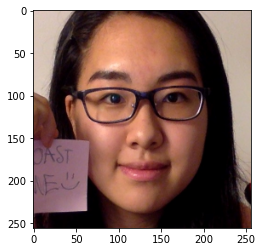

In [9]:
imgs = lookup_img('3by2xz')
img = imgs[0]
plt.imshow(to_rgb(img))

In [9]:
input_dict = {}
input_dict['input_1'] = img.reshape((1,img.shape[0],img.shape[1],3)).astype(np.float32)
input_dict['input_2'] = tokenizer.texts_to_sequences([u'You look like '])
model(input_dict)

<tf.Tensor: shape=(1, 4, 4000), dtype=float32, numpy=
array([[[ 0.00495812, -0.00978796, -0.00742598, ...,  0.00260977,
          0.02185226,  0.01347353],
        [ 0.00577816, -0.00783534, -0.00857792, ..., -0.00172348,
          0.02127137,  0.01151799],
        [ 0.00497851, -0.00374222, -0.00945744, ..., -0.00079176,
          0.01439389,  0.00726691],
        [ 0.00456478, -0.00158427, -0.00582796, ..., -0.00228932,
          0.00925785,  0.00497183]]], dtype=float32)>

In [22]:
gen = generator()
for val in [next(gen) for _ in range(1)]:
    print(val['input_2'])
    batch_of_one = split_input_target(val)
    x,y = batch_of_one[0], batch_of_one[1]
    print('input_sequence (as text)')
    texts = x['input_2']
    texts = [[val] for val in texts]
    seq = tokenizer.sequences_to_texts(texts)
    print(seq)
    print('output_sequence (as text)')
    y = [[val] for val in y]
    print(tokenizer.sequences_to_texts(y))

[   0    4  370  331 1701 1702    1]
input_sequence (as text)
['', 'a', 'future', 'cat', 'litter', 'spokeswoman']
output_sequence (as text)
['a', 'future', 'cat', 'litter', 'spokeswoman', 'endofseq']


In [10]:
dataset = tf.data.Dataset.from_generator(generator, output_types={'input_1':tf.float32,'input_2':tf.int32},
                                        output_shapes={'input_1':tf.TensorShape([None,None,3]),
                                                      'input_2':tf.TensorShape([None])})

In [33]:
# for text only
dataset = tf.data.Dataset.from_tensor_slices(tensor)
#dataset = dataset.batch(50, drop_remainder=True)

In [34]:
dataset

<TensorSliceDataset shapes: (50,), types: tf.int32>

In [35]:
tokenizer.texts_to_sequences(['endofseq'])

[[1]]

In [36]:
#@tf.function
SEQ_LENGTH = 10
def restructure_seq(seq):
    input_text = [0] + seq[:-1]
    output_text = seq[1:]
    if len(seq)>SEQ_LENGTH:
        input_text = input_text[:SEQ_LENGTH]
        output_text = output_text[:SEQ_LENGTH]
    else:
        additional = SEQ_LENGTH - len(seq)
        #seq = seq + 
    index = seq.index(0)
    #input_seq = 

def split_input_target(chunk):
    input_text = chunk['input_2'][:-1]
    output_text = chunk['input_2'][1:]
    #print(len(input_text), len(output_text))
    #input_text = tf.pad(input_text, padding='post', maxlen=100)
    #output_text = tf.keras.preprocessing.sequence.pad_sequences([output_text], padding='post', maxlen=100)
    #tf.print(input_text, output_text)
    return {'input_1': chunk['input_1'], 'input_2': input_text}, output_text

def split_input_target_text(chunk):
    input_text = chunk[:-1]
    output_text = chunk[1:]
    return input_text, output_text
dataset = dataset.map(split_input_target_text)

In [14]:
for (input_img, input_text), output_text in dataset.take(1):
    print(type(input_img))
    print(input_text)
    print(output_text)

ValueError: too many values to unpack (expected 2)

In [37]:
dataset

<MapDataset shapes: ((49,), (49,)), types: (tf.int32, tf.int32)>

In [38]:
BATCH_SIZE = 128
BUFFER_SIZE = 200
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset

<BatchDataset shapes: ((None, 49), (None, 49)), types: (tf.int32, tf.int32)>

In [39]:
test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
train_dataset = dataset.enumerate().filter(lambda x,y:x % 5 != 0).map(lambda x,y: y)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x0000026698835700>. It was defined on this line: test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x0000026698835700>. It was defined on this line: test_dataset = dataset.enumerate().filter(lambda x,y: x % 5 == 0).map(lambda x,y: y)
, which must contain a single l

In [40]:
EPOCHS = 10

def logits_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam',loss=logits_loss)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          1024000   
_________________________________________________________________
gru (GRU)                    (128, None, 1024)         3938304   
_________________________________________________________________
gru_1 (GRU)                  (128, None, 1024)         6297600   
_________________________________________________________________
dense (Dense)                (128, None, 4000)         4100000   
Total params: 15,359,904
Trainable params: 15,359,904
Non-trainable params: 0
_________________________________________________________________


In [42]:
train_dataset

<MapDataset shapes: ((None, 49), (None, 49)), types: (tf.int32, tf.int32)>

In [45]:
for input_text, output_text in train_dataset.take(1):
    print(input_text.numpy())
    print(output_text.numpy())

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  5 283 375 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [283 375  45 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [46]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_prefix, save_weights_only=True)

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

In [49]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, initial_epoch=0,
         callbacks=[checkpoint_callback,early_stopping])

Epoch 1/10
     40/Unknown - 277s 7s/step - loss: 0.4519

InvalidArgumentError:  assertion failed: [Condition x == y did not hold element-wise:] [x (logits_loss/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [36 49] [y (logits_loss/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [128 49]
	 [[node logits_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-40-e8b1843a5f63>:4) ]] [Op:__inference_test_function_11074]

Function call stack:
test_function


In [12]:
def generate_text(model, img, start_string, new_line_freq=20, temperature=.75):
    num_generate = 15
    img = np.array([img], dtype=np.float32)/255.
    seq = tokenizer.texts_to_sequences([start_string])
    print(seq)
    input_dict = {'input_1': img,
              'input_2': seq}
    #input_eval = tf.expand_dims(input_eval, 0)
    start_length = len(input_dict['input_2'])
    model.reset_states()
    text_generated = []
    for i in range(num_generate):
        predictions = model(input_dict)
        predictions = tf.squeeze(predictions,0) #remove batch dimension
        predictions = predictions / temperature
        predicted_word = ''
        #while predicted_word!='endofseq':
        predicted_id = tf.random.categorical(predictions,num_samples=1)[-1,0].numpy()

        input_dict['input_2'][0].append(predicted_id)
        #print(input_dict['input_2'])
        predicted_word = tokenizer.sequences_to_texts([[predicted_id]])[0]
        #print(predicted_word)

        text_generated.append(predicted_word + ' ')
        #if predicted_word == 'endofseq':
         #   break
        if (i-start_length) % 20 == 0:
              text_generated.append('\n')
    print(input_dict['input_2'])
    return (start_string + ''.join(text_generated))

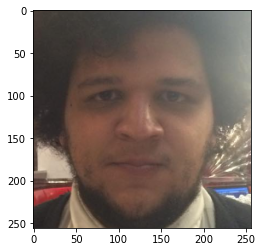

In [67]:
imgs = lookup_img('3eq9to')
plt.imshow(to_rgb(imgs[0]))

In [13]:
#model = RoastBot(vocab_size=4000, embedding_dim=256,batch_size=1,conv_arr=conv_arr,rnn_arr=rnn_arr)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
#model.build(tf.TensorShape([1,None]))

In [19]:
generate_text(model, to_rgb(imgs[0]), u'You look like ', temperature=.99)

[[2, 10, 7]]
[[2, 10, 7, 295, 3, 15, 35, 5, 25, 82, 33, 33, 1, 1, 205, 78, 8, 24]]


'You look like homeless the \non out your looks too as as endofseq endofseq actually still of this '